In [166]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [142]:
# create a function to evaluate the models
def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    return [accuracy, precision, recall]

In [64]:
# Read the Excel file
df = pd.read_excel('C:\\Users\\Phil\\CaseStudy\\PSP_DATA_PREP.xlsx')

scaler = MinMaxScaler()
df['hour'] = scaler.fit_transform(df['hour'].to_numpy().reshape(-1,1))
df['day_of_week'] = scaler.fit_transform(df['day_of_week'].to_numpy().reshape(-1,1))

# Display the data
df.head()

,tmsp,attempts,success,PSP,3D_secured,fee,hour,day_of_week,month,amount_norm,country_Austria,country_Germany,country_Switzerland,card_Diners,card_Master,card_Visa
0,2019-01-01 00:01:11,2,1,UK_Card,0,4.0,0.0,0.166667,1,0.133013,0,1,0,0,0,1
1,2019-01-01 00:02:49,2,1,UK_Card,1,4.0,0.0,0.166667,1,0.371795,0,1,0,1,0,0
2,2019-01-01 00:04:33,1,0,Simplecard,0,0.5,0.0,0.166667,1,0.189103,1,0,0,1,0,0
3,2019-01-01 00:06:41,2,0,Simplecard,0,1.5,0.0,0.166667,1,0.442308,0,0,1,0,1,0
4,2019-01-01 00:08:46,1,1,UK_Card,0,3.0,0.0,0.166667,1,0.177885,0,1,0,0,1,0


In [221]:
df_success = df[df['success'] == 1]
df_success = df_success.drop(columns=['tmsp', 'fee', 'success', 'month'], axis=1)


X = df_success.drop("PSP", axis=1)
y = df_success["PSP"].astype('category').cat.codes

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the SMOTE algorithm to balance the data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Apply the RandomUnderSampler algorithm to balance the data
# rus = RandomUnderSampler(random_state=42)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train.values).float()
y_train = torch.tensor(y_train.values).long()
X_test = torch.tensor(X_test.values).float()
y_test = torch.tensor(y_test.values).long()    


In [240]:
# Define the model architecture
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super(Classifier, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.middle_1 = nn.Linear(hidden_size, hidden_size)
        self.middle_2 = nn.Linear(hidden_size, hidden_size)
        self.middle_3 = nn.Linear(hidden_size, hidden_size)
        self.middle_4 = nn.Linear(hidden_size, hidden_size)
        self.middle_5 = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.norm = nn.LayerNorm(hidden_size)
    
    def forward(self, x):
        out = self.dropout(self.relu(self.input_layer(x)))
        out = self.norm(self.relu(self.middle_1(out)))
        out = self.norm(self.relu(self.middle_2(out)))
        out = self.norm(self.relu(self.middle_3(out)))
        out = self.norm(self.relu(self.middle_4(out)))
        out = self.norm(self.relu(self.middle_5(out)))
        out = self.output_layer(out)
    
        return out

Epoch [500/5000], Loss: 1.3631, Accuracy: 29.00%
Epoch [1000/5000], Loss: 1.3457, Accuracy: 28.41%
Epoch [1500/5000], Loss: 1.3341, Accuracy: 31.15%
Epoch [2000/5000], Loss: 1.3225, Accuracy: 31.69%
Epoch [2500/5000], Loss: 1.3128, Accuracy: 32.67%
Epoch [3000/5000], Loss: 1.3021, Accuracy: 32.27%
Epoch [3500/5000], Loss: 1.2911, Accuracy: 31.10%
Epoch [4000/5000], Loss: 1.2816, Accuracy: 30.37%
Epoch [4500/5000], Loss: 1.2747, Accuracy: 30.95%
Epoch [5000/5000], Loss: 1.2686, Accuracy: 31.05%


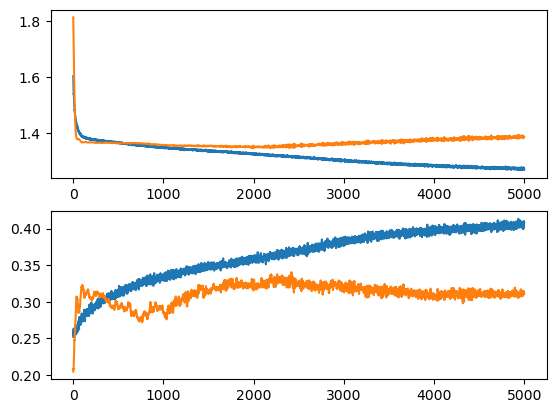

In [241]:
# Define the hyperparameters
input_size = 11
num_classes = 4
learning_rate = 0.0001
num_epochs = 5000
hidden_size = 25

# Create the model
model = Classifier(input_size, num_classes, hidden_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training 
training_loss=[]
training_acc=[]
test_loss=[]
test_acc=[]

for epoch in range(num_epochs):
    model.train()
    # Forward pass
    outputs = model(X_train)
    _, predicted = torch.max(outputs.data, 1)
    loss = criterion(outputs, y_train.long())
    training_loss.append(loss.item())
    
    acc = (predicted == y_train).sum().item()/y_train.size(0)
    training_acc.append(acc)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs.data, 1)
        
        test_loss.append(criterion(outputs, y_test).item())


        # Calculate the accuracy
        total = y_test.size(0)
        correct = (predicted == y_test).sum().item()
        test_acc.append(correct / total)
        # Print the accuracy for every 100 epochs
        if (epoch+1) % (num_epochs/10) == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {100*correct/total:.2f}%")


fig, axs = plt.subplots(2)
axs[0].plot(training_loss)
axs[0].plot(test_loss)
axs[1].plot(training_acc)
axs[1].plot(test_acc)

Accuracy on test data: 31.05%
Accuracy: 0.3105134474327628
Precision: 0.42210488587583445
Recall: 0.3105134474327628


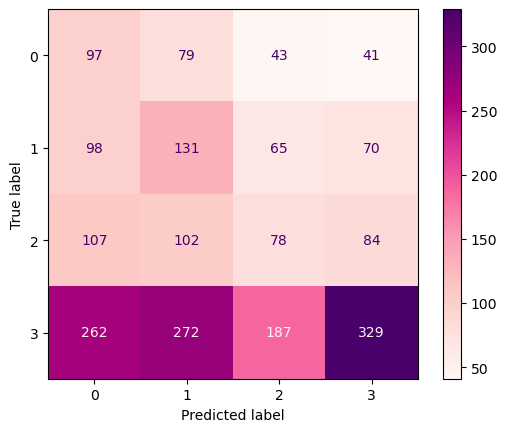

In [242]:
# Set the model to evaluation mode
model.eval()

# Forward pass on the test data
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

# Calculate the accuracy
total = y_test.size(0)
correct = (predicted == y_test).sum().item()
accuracy = correct / total

# Print the accuracy
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

# Convert the predicted and actual labels to numpy arrays
y_pred = predicted.numpy()
y_actual = y_test.numpy()

# Evaluate the model 
score = evaluate(y_actual, y_pred)
print(f"Accuracy: {score[0]}\nPrecision: {score[1]}\nRecall: {score[2]}")

# Create the confusion matrix
cm = confusion_matrix(y_actual, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='RdPu')

In [228]:
min_index = test_loss.index(min(test_loss))
print(f"Minimum test loss: {test_loss[min_index]} at epoch {min_index}")

Minimum test loss: 1.3204889297485352 at epoch 323
